# Lab Assignment 1 - Classification

**----- Import all libraries here -----**

In [69]:
# data manipulation
import pandas as pd
import numpy as np
import math
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


# 1. Data Analysis 

<span style="color:blue">Load the CSV file into a *DataFrame* object named **pima** using Pandas to examine the dataset and perform data cleaning:</span>
    
<span style="color:blue">1) Print the dtype of each column to review the data types of the attributes in the dataset. *(2 points)*</span>

In [70]:
def check_for_empty_values(dataframe):
    count = 0
    for index, row in dataframe.iterrows():
        for element in row:
            if math.isnan(element):  # Zeros are NOT considered missing values, but noisy data
                count += 1
    print("Number of empty values: {}".format(count))
    
def fill_empty_values(dataframe, with_zero=False):
    for index, row in dataframe.iterrows():
        for column in dataframe:
            col = dataframe[dataframe[column]!=0][column]
            mean = col.mean()
            standard_deviation = col.std()
            if with_zero==False:
                if math.isnan(row[column]):
                    replacement_value = mean + random.uniform(-standard_deviation, standard_deviation)
                    if column == 'DiabetesPedigreeFunction':
                        replacement_value=round(replacement_value, 3)
                    elif column == 'BMI':
                        replacement_value=round(replacement_value, 1)
                    else:
                        replacement_value=round(replacement_value)
                    dataframe.at[index, column] = replacement_value
                    #print("Replaced empty value with {}".format(replacement_value))
            else:
                if math.isnan(row[column]) or row[column]==0:
                    old_value = row[column]
                    mean = col.mean()
                    standard_deviation = col.std()
                    replacement_value = mean + random.uniform(-standard_deviation, standard_deviation)
                    if column == 'DiabetesPedigreeFunction':
                        replacement_value=round(replacement_value, 3)
                    elif column == 'BMI':
                        replacement_value=round(replacement_value, 1)
                    else:
                        replacement_value=round(replacement_value)
                    dataframe.at[index, column] = replacement_value
                    #print("Replaced {} {} with {}".format(column, old_value, replacement_value))

def do_train_test(model, x_train, x_test, y_train, y_test):
    if model == 'Gaussian NB':
        Classifier = GaussianNB()
    elif model == 'KNN':
        Classifier = KNeighborsClassifier()
    elif model == 'SVM':
        Classifier = SVC()
    elif model == 'LR':
        Classifier = LogisticRegression()
    elif model == 'DT':
        Classifier = DecisionTreeClassifier()
    Classifier.fit(x_train, y_train)
    Class_accuracy = Classifier.score(x_test, y_test)
    Class_F1 = f1_score(y_test, Classifier.predict(x_test))
    return Class_accuracy, Class_F1


In [62]:
pima = pd.read_csv("diabetes.csv") 
print(pima.dtypes)


Pregnancies                   int64
Glucose                       int64
BloodPressure               float64
SkinThickness               float64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


<span style="color:blue">2) Are there any missing values in the dataset? Print out the total count of missing values for the attributes in the dataset. How would you handle the missing values without deleting any record? Develop and execute an operation for that purpose accordingly. *(3 points)*</span>

In [63]:
check_for_empty_values(pima)
fill_empty_values(pima)
check_for_empty_values(pima)

Number of empty values: 3
Replaced empty value with 65.0
Replaced empty value with 19.0
Replaced empty value with 0.302
Number of empty values: 0


<span style="color:red">As explained in IVLE, values of 0 are treated as noisy data, while only those completely empty values will be treated as "empty". These in question return NaN.
In order to deal with them they are identified as the elements are being iterated and then when identified they are replaced by a random number consisting of the mean of the column plus or minus two times the standard deviation of the column. While not a perfect approach, it should stay within the expected values</span>




<span style="color:blue">3) Examine Outcome by generating a bar plot showing the count of “0” and “1” in Outcome. Write down any of your insights from observing the bar plot. *(3 points)*</span>

Outcome
0    500
1    268
Name: Outcome, dtype: int64
Number of positive cases practically doubles number of negative cases


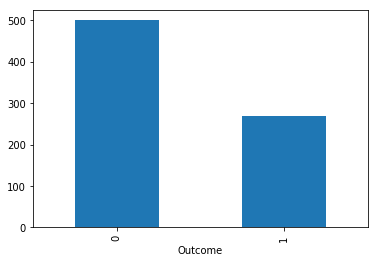

In [64]:
outcome = pima.groupby('Outcome')['Outcome'].count()
print(outcome)
ax = outcome.plot.bar(x='Outcome', y='Value')
print('Number of positive cases practically doubles number of negative cases')


<span style="color:red">The number of positive cases practically doubles number of negative cases</span>

<span style="color:blue">4) Generate a pairwise relationship scatterplot (8x8 subplots) using __sb.pairplot(pima, vars=feature_column_names, hue='Outcome')__. *(2 points)*</span>

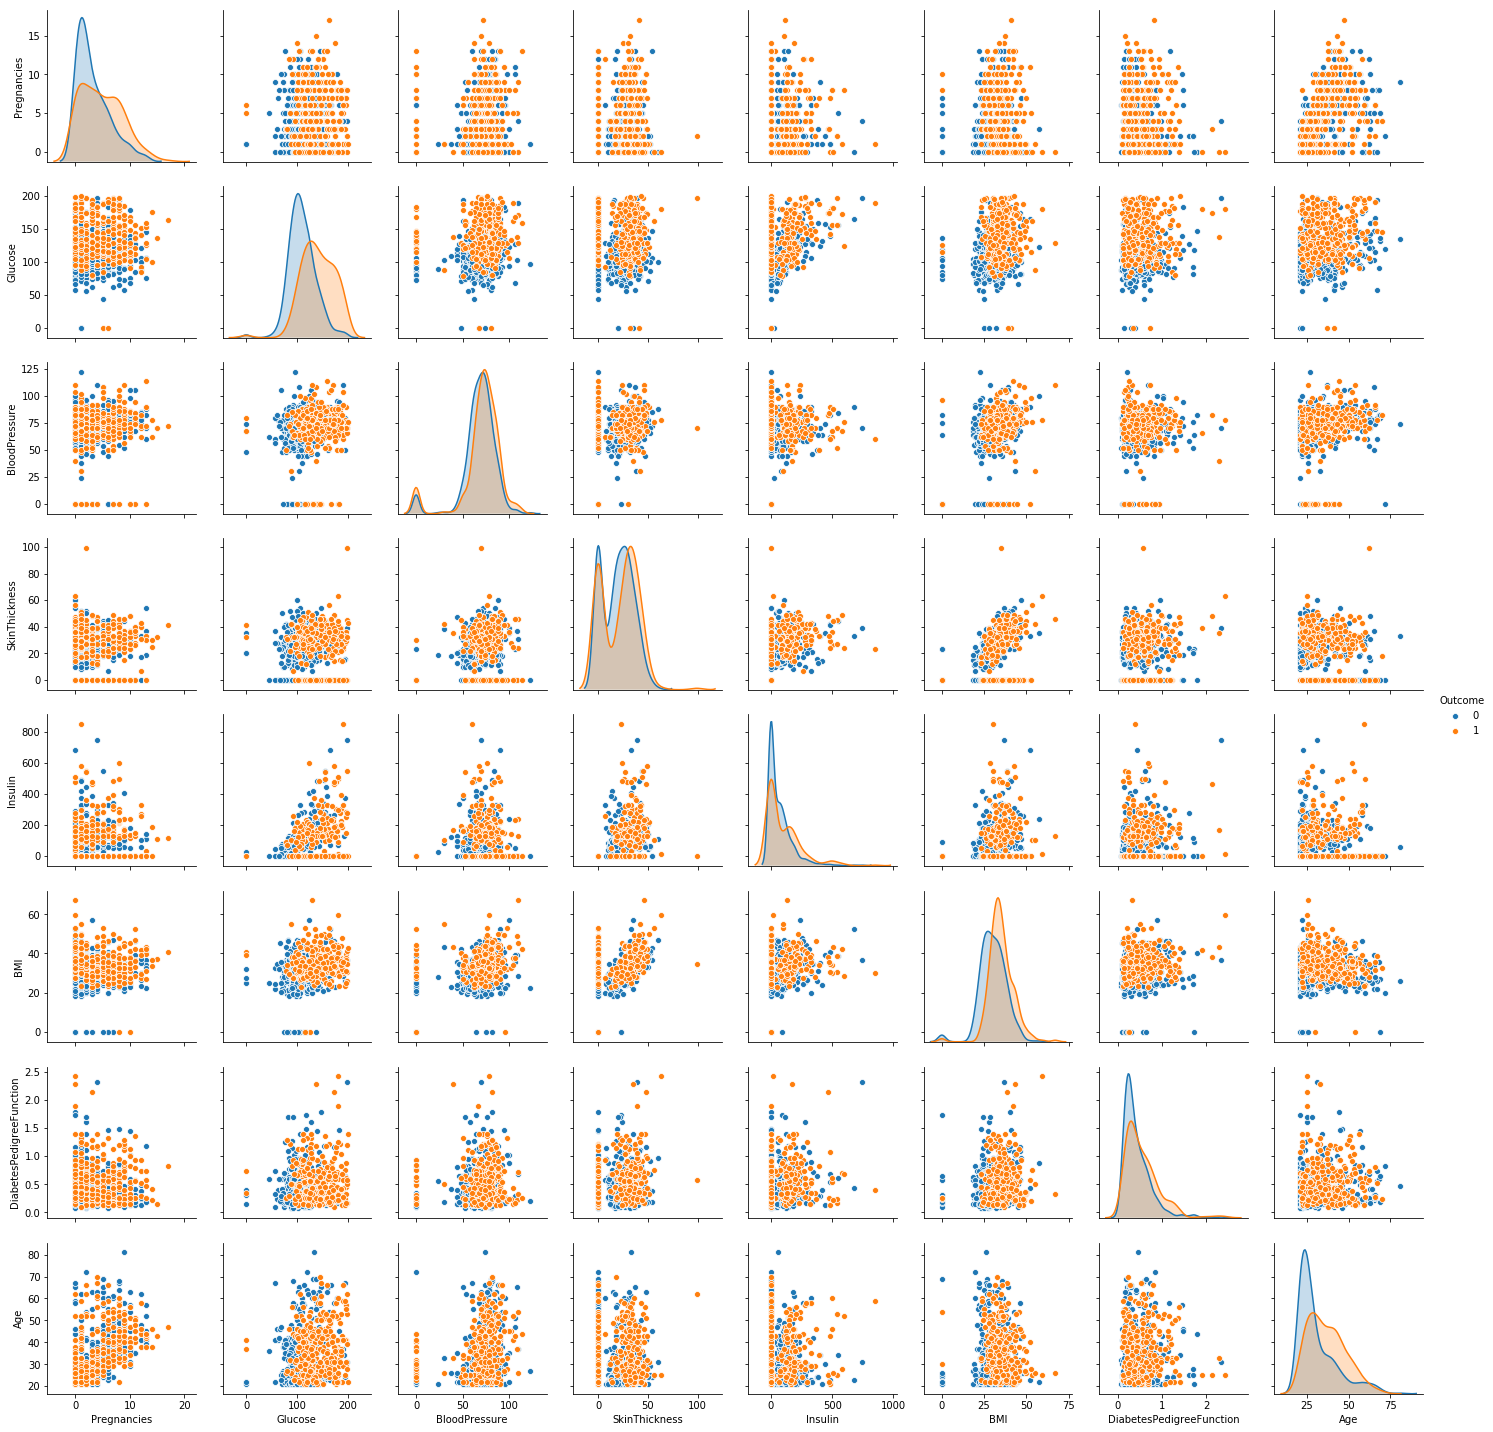

In [29]:
sb.pairplot(pima, vars=('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI','DiabetesPedigreeFunction', 'Age'), hue='Outcome')


<span style="color:blue">5) Generate a 9x9 heatmap plot showing the co-variance between any two features (including target). *(2 points)*<br/>
    
<span style="color:blue">_(Hint: use __sb.clustermap(pima.corr(), annot=True)__ to plot co-variance heatmap.)_</span>

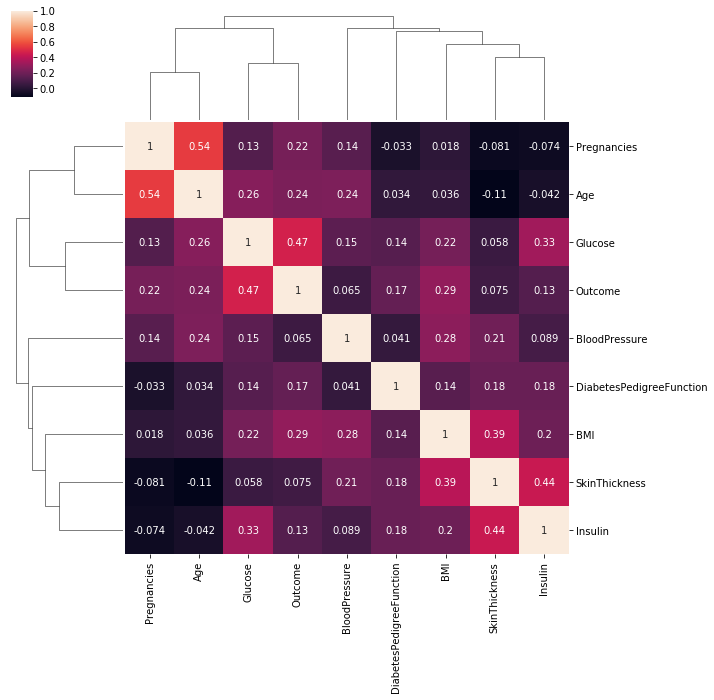

In [30]:
sb.clustermap(pima.corr(), annot=True)


<span style="color:blue">6) What are the insights you gained from the two plots generated from 4) and 5)? *(3 points)*</span>

<span style="color:blue">_(Hint: think about how to perform feature selection based on the observations, which may be helpful for constructing your best model in Section 4.)_</span>

<span style="color:blue">There is a high correlation between Glucose levels, High Blood Pressure and Skin Thickness in regards to the Outcome</span>


# 2. Feature Transformation

We observe that all the variables in the dataset except the target variable *Outcome* are continuous. In this section, you will perform feature transformation on the continuous variables to generate two sets of features that will be used in the subsequent classification task.

**Feature set 1 - Continuous to Categorical**

<span style="color:blue">1) Often when dealing with continuous variables like *BMI* or *BloodPressure*,  we may wish  to transform these continuous variables into categorical variables, which may be better predictors of *Outcome*. This transformation can be achieved as follows: cut the continuous values of each feature into non-overlapping buckets.  Perform this operation on all 8 continuous variables.  You are to devise you own method to cut the continuous values into buckets. Name the resulting DataFrame as __pima1__. pima1 should still contains 9 conlumns with the same set of column names as pima. Use **pima1.head()** to show the top rows. *(5 points)*</span>
    
<span style="color:blue">*(Hint: you can use **pandas.cut()** or **pandas.qcut()** to convert continuous feature to categorical feature. e.g. For Glucose, if you wish to adopt the glucose level guidelines given by American Diabetes Association, you can convert its values into 3 groups:<br/>*
*- Normal > 140mg/dl of glucose,<br/>*
*- Prediabete 140-199mg/dl of glucose,<br/>*
*- Diabetes > 200mg/dl of glucose<br/>*
*using  **pd.cut(pima[’Glucose’],[50,139.99,199.99,250], labels=[0, 1, 2])**. Or you can use **pd.qcut(pima[’Glucose’],4, labels=[0,1,2,3])** to cut the values according to quantile-based discretization function.)*
</span>

In [31]:
pima1 = pima.copy()
pima1['Pregnancies'] = pd.qcut(pima1['Pregnancies'],3, labels=[0,1,2])
pima1['Glucose'] = pd.cut(pima1['Glucose'],[50,139.99,199.99,250], labels=[0, 1, 2])
pima1['BloodPressure'] = pd.qcut(pima1['BloodPressure'],3, labels=[0,1,2])
pima1['SkinThickness'] = pd.qcut(pima1['SkinThickness'],3, labels=[0,1,2])
pima1['Insulin'] = pd.cut(pima1['Insulin'],[-1,29,230,1000], labels=[0, 1, 2])
pima1['BMI'] = pd.cut(pima1['BMI'],[-1,18.499,24.999,29.999,90], labels=[0, 1, 2, 3])
pima1['DiabetesPedigreeFunction'] = pd.qcut(pima1['DiabetesPedigreeFunction'],3, labels=[0,1,2])
pima1['Age'] = pd.qcut(pima1['Age'],3, labels=[0,1,2])

print(pima1.head())

  Pregnancies Glucose BloodPressure SkinThickness Insulin BMI  \
0           2       1             1             2       0   3   
1           0       0             0             1       0   2   
2           2       1             0             0       0   1   
3           0       0             0             1       1   2   
4           0       0             0             2       1   3   

  DiabetesPedigreeFunction Age  Outcome  
0                        2   2        1  
1                        1   1        0  
2                        2   1        1  
3                        0   0        0  
4                        2   1        1  


<span style="color:blue">2) Next, we convert the generated categorical features into binary features using the **one-hot encoding scheme**. Assume the continuous feature has m numerical labels. The one-hot encoding scheme will results in a vector of size m with only one of the values as 1 (indicating it as active). Use **pima1.head()** to show the top rows of the encoded pima1. *(2 points)*</span>

<span style="color:blue">*(Hint: you can use **pd.getdummies()** to convert each categorical feature in pima1 into multiple binary features.)*</span>

In [32]:
pima1 = pd.get_dummies(pima1)

print(pima1.head())

   Outcome  Pregnancies_0  Pregnancies_1  Pregnancies_2  Glucose_0  Glucose_1  \
0        1              0              0              1          0          1   
1        0              1              0              0          1          0   
2        1              0              0              1          0          1   
3        0              1              0              0          1          0   
4        1              1              0              0          1          0   

   Glucose_2  BloodPressure_0  BloodPressure_1  BloodPressure_2  ...  BMI_0  \
0          0                0                1                0  ...      0   
1          0                1                0                0  ...      0   
2          0                1                0                0  ...      0   
3          0                1                0                0  ...      0   
4          0                1                0                0  ...      0   

   BMI_1  BMI_2  BMI_3  DiabetesPedigr

<span style="color:blue">3) Discuss whether the use of one-hot encoding can be omitted and why? *(3 points)*</span>

<span style="color:red">The usage of one-hot encoding helps simplify the variability of the data into simple binary terms that will range less. However this will also include the number of features by creating 'new' ones to fully represent the extent of each category. With correct information handling, this should not be required

**Feature set 2 - Features normalization**

<span style="color:blue">4) For the second feature set, we normalize the values of 8 continuous variables. For each variable, we apply the transformation using the formula **z=(x−u)/s**, where u and s are the mean and standard deviation of the variable values. Name the resulting DataFrame as **pima2**, and show the top rows using pima2.head(). *(2 points)*</span>

<span style="color:blue">*(Hint: you can use **StandardScaler** from scikit-learn for standadization purpose)*</span>

In [33]:
pima2 = pima.copy()
pima2_no_outcome = pima2.drop(['Outcome'], axis=1)
scaler = StandardScaler()

pima2_no_outcome = scaler.fit_transform(pima2_no_outcome)
pima2_no_outcome = pd.DataFrame(pima2_no_outcome, columns=['Pregnancies', 'Glucose', 'BloodPressure', 
                                                'SkinThickness','Insulin', 'BMI','DiabetesPedigreeFunction', 
                                                'Age'])
pima2.update(pima2_no_outcome)

print(pima2.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.848324       0.150083       0.908291 -0.692891  0.204013   
1    -0.844885 -1.123396      -0.159984       0.531836 -0.692891 -0.684422   
2     1.233880  1.943724      -0.263340      -1.287695 -0.692891 -1.103255   
3    -0.844885 -0.998208      -0.159984       0.155381  0.123302 -0.494043   
4    -1.141852  0.504055      -1.503611       0.908291  0.765836  1.409746   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.469822  1.425995        1  
1                 -0.363953 -0.190672        0  
2                  0.605763 -0.105584        1  
3                 -0.919803 -1.041549        0  
4                  5.487574 -0.020496        1  


<span style="color:blue">5) Briefly discuss whether Feature set 1 or Feature set 2 is more useful for training classification models and why? Also comment on whether feature normalization is necessary in this case. *(3 points)*</span>

<span style="color:red">At a first glance, Feature set 1 holds superiority to feature set 2. First because binary values will result in faster calculations and easier categorization and second because in a dataset that is not substantially bloated with features, it will artificially create a few more to help with the decision of the same.</span>

# 3. Model Construction

Your task in this section is to use the derived feature sets from previous section to construct classification models for diabetes outcome prediction (0 or 1).  We have splitted the data into training and test sets for you as shown below (you need to run the cell below).

In [34]:
# pima1 split
x1 = pima1.drop(columns='Outcome')
y1 = pima1['Outcome']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.25, random_state=0)

# pima2 split
x2 = pima2.drop(columns='Outcome')
y2 = pima2['Outcome']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.25, random_state=0)

print(x1.shape, y1.shape)
print(x2.shape, y2.shape)

(768, 25) (768,)
(768, 8) (768,)


<span style="color:blue">1) Experiment with the 5 classification models below from scikit-learn with their default hyperparameter settings on pima1 and pima2 (You should thus perform 5x2 times model training and evaluation):<br/></span>

<span style="color:blue">- Gaussian naive bayes</span><br/>
<span style="color:blue">- KNN</span><br/>
<span style="color:blue">- SVM</span><br/>
<span style="color:blue">- logistic regression</span><br/>
<span style="color:blue">- decision tree<br/></span>
    
<span style="color:blue">You should perform model training on x_train1 and x_train2,  and perform evaluation on x_test1 and x_test2 respectively.  Use **accuracy** and **weighted F1** as evaluation metrics, and save the results of different models in the defined lists **pima1_acc**, **pima2_acc**, **pima1_f1**, **pima2_f1**. Note that the order of results in each list should match the model order provided in **model_names**. Print the **accuracy_record** table and **F1_record** table using the provided code. *(20 points)*</span>

In [35]:
model_names = ['Gaussian NB', 'KNN', 'SVM', 'LR', 'DT']
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []

# --- Your code here ---
for model in model_names:
    pima1_accuracy, pima1_F1 = do_train_test(model, x_train1, x_test1, y_train1, y_test1)
    pima2_accuracy, pima2_F1 = do_train_test(model, x_train2, x_test2, y_train2, y_test2)
    pima1_acc.append(pima1_accuracy)
    pima2_acc.append(pima2_accuracy)
    pima1_f1.append(pima1_F1)
    pima2_f1.append(pima2_F1)


# --- End of your code ---

accuracy_record = pd.DataFrame({'Model': model_names, 'pima1_acc': pima1_acc, 'pima2_acc': pima2_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

F1_record = pd.DataFrame({'Model': model_names, 'pima1_f1': pima1_f1, 'pima2_f1': pima2_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

             pima1_acc  pima2_acc  acc_mean
Model                                      
Gaussian NB   0.734375   0.765625     0.750
KNN           0.739583   0.812500     0.780
SVM           0.765625   0.776042     0.770
LR            0.765625   0.802083     0.780
DT            0.640625   0.744792     0.690
avg           0.729167   0.780208     0.754


             pima1_f1  pima2_f1  F1_mean
Model                                   
Gaussian NB  0.648276  0.594595    0.620
KNN          0.590164  0.689655    0.640
SVM          0.579439  0.598131    0.590
LR           0.594595  0.654545    0.620
DT           0.473282  0.608000    0.540
avg          0.577151  0.628985    0.602


<span style="color:blue">2) According to the results above, which feature set is better, pima1 or pima2? Select one to be used in the following tasks. *(2 points)*</span>

<span style="color:red">pima2 shows overall a greater accuracy than pima1 except for Gaussian NB when it comes to the Weighted F1. However seeing as this difference is marginal comparing to the better results in all the other tests, pima2 will be the one selected.</span>


<span style="color:blue">3) Select one classification model from 1). Discuss which are the hyperparameters that may affect the model performance the most. Perform grid search with 10 folds cross-validation for tuning those hyperparameters on the training set of either pima1 or pima2 (according to your choice in 2)), using accuracy as the scoring metric. Print the configuration of the best selected model and its prediction **accuracy** and **weighted F1** scores on the corresponding test set. *(15 points)*</span>

<span style="color:blue">*(Hint: for each selected hyperparameter, you need to prepare a list of reasonable values for tunining. Use **sklearn.model_selection.GridSearchCV** for grid search.)*</span>

<span style="color:red">As the one with the highest accuracy and F1 in the previous example, KNN will be used for the below. Among its hyperparameters, 4 of them stand out specifically as those who can be the most influential ones to change the outcome of the accuracy. These are Neighbors, Weights, Leaf Size and P.</span>


In [36]:
parameters = {'n_neighbors':(5,7,9), 'weights':('uniform', 'distance'), 'leaf_size':range(25,35), 'p':(1,2)}
knn = KNeighborsClassifier()
GridSearch = GridSearchCV(knn, parameters, cv=10)

GridSearch.fit(x_train2, y_train2)
best_knn = GridSearch.best_estimator_

best_knn.fit(x_train2, y_train2)
best_accuracy = best_knn.score(x_test2, y_test2)
best_f1 = f1_score(y_test2, best_knn.predict(x_test2))

print(GridSearch.best_estimator_)
print(best_accuracy)
print(best_f1)

KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=1,
           weights='distance')
0.7864583333333334
0.6306306306306306


<span style="color:blue">4) Besides accuracy and F1 scores, one can look at the confusion matrix to understand the model's prediction behaviour. Compare confusion matrix on test data before and after hyperparameter tuning for the selected model in 3). Discuss any of your observations or insights. *(5 points)*</span>

<span style="color:blue">*(Hint: you can use **confusion_matrix** from scikit-learn, and use **sb.heatmap(conf_matrix, annot=True)** to plot a corresponding heatmap for better visualization.)*</span>

[[116  14]
 [ 27  35]]


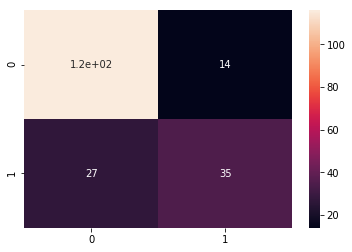

In [37]:
conf_matrix = confusion_matrix(y_test2, best_knn.predict(x_test2))
print(conf_matrix)
sb.heatmap(conf_matrix, annot=True)

<span style="color:red">Results are decently acceptable, giving about 75% of the answers correct as expected. However it is still a considerable error rate which would make this particular solution to be imprecise.</span>


<span style="color:blue">5) You can get feature importances for some tree-based classifiers in scikit-learn via **clf.feature_importances_**. Example code for plotting pima2 feature importances for an adaboost decision tree classifier has been given below. Generate the plot and describe your observations. Briefly describe how the feature importances for the given classifier can be computed. *(5 points)*</span>

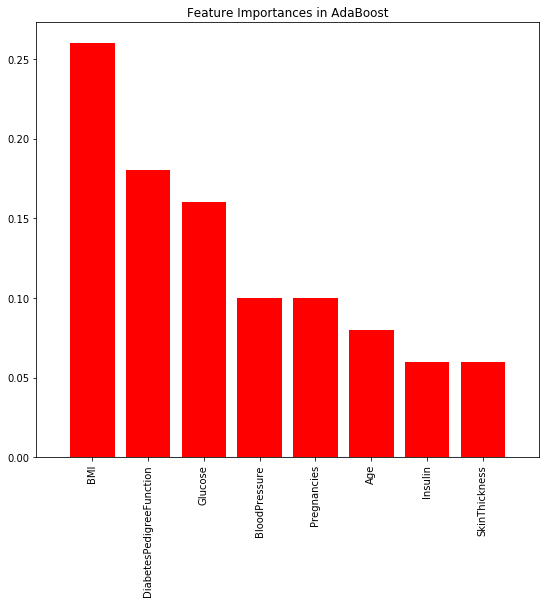

In [38]:
x_train = x_train2
y_train = y_train2

ada = AdaBoostClassifier(random_state=0)
ada.fit(x_train, y_train)
relevants = ada.feature_importances_
indices = np.argsort(relevants)[::-1]

# Plot feature importances
plt.figure(1, figsize=(9, 8))
plt.title('Feature Importances in AdaBoost')
plt.bar(range(x_train.shape[1]), relevants[indices], color='r', align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

<span style="color:red">Some of the results observed here check out with previously observed correlation results, such as the Glucose and BMI being important factors. However it also disproves the importance of some of the other featues, just like Insulin and Skin Thickness, which logically would figure to be related to BMI and Glucose and therefore to the final condition, however this is mathematically incorrect.</span>


<span style="color:blue">6)  Think  about  how  to  compute  the  feature  importances  for  other  classifiers  in  1).   Select  one classifier (except decsion tree), and generate a similar bar plot showing the feature importances. *(8 points)*</span>

Feature  Accuracy
8
Pregnancies        0.634785
Glucose        0.687366
BloodPressure        0.624616
SkinThickness        0.59914
Insulin        0.671579
BMI        0.635115
DiabetesPedigreeFunction        0.588801
Age        0.619402


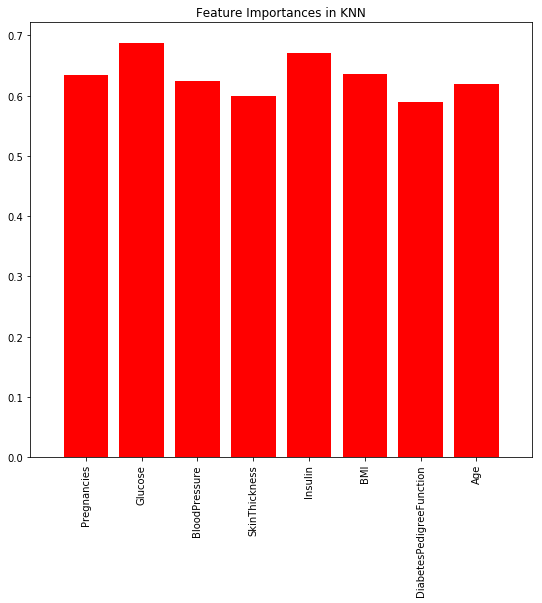

In [39]:
n_feats = x_test2.shape[1]

print('Feature  Accuracy')
print(n_feats)
relevant = []
col_index = []
for i in x_test2:
    X = x_test2[i].values.reshape(-1, 1)
    scores = cross_val_score(best_knn, X, y_test2)
    relevant.append(scores.mean())
    col_index.append(i)
    print('%s        %g' % (i, scores.mean()))
    
plt.figure(1, figsize=(9, 8))
plt.title('Feature Importances in KNN')
plt.bar(range(x_test2.shape[1]), relevant, color='r', align='center')
plt.xticks(range(x_train2.shape[1]), col_index, rotation=90)
plt.xlim([-1, x_train2.shape[1]])
plt.show()

# 4. Best Model Construction

<span style="color:blue">1) Generate the best classifier you can for predicting the diabetes outcome. Show the classification **accuracy**, **weighted F1** and **confusion matrix** on test data (you should keep the original train test split). Besides that, you can also show any result or plot that are helpful for us to better understand your model. Write a short description of you model indicating the elements that help to improve prediction. You may use any classifier including but not limited to those experimented above. Marks will be given based on your model performance and description. *(13 points)*</span>

<span style="color:blue">*(Hint: you can think about improving the model performance from different aspects: e.g. improve the feature set; choose a more sophisticated classifier such as ensemble models; or improve the training process via careful hyperparameter tunning or sampling techniques.)*</span>

In [84]:
best_pima = pima.copy()
processing_best_pima = best_pima.drop(['Pregnancies','Outcome'],axis=1)
fill_empty_values(processing_best_pima, True)
best_pima.update(processing_best_pima)

best_pima_no_outcome = best_pima.drop(['Outcome'], axis=1)
scaler = StandardScaler()
best_pima_no_outcome = scaler.fit_transform(best_pima_no_outcome)
best_pima_no_outcome = pd.DataFrame(best_pima_no_outcome, columns=['Pregnancies', 'Glucose', 'BloodPressure', 
                                                'SkinThickness','Insulin', 'BMI','DiabetesPedigreeFunction', 
                                                'Age'])
best_pima.update(best_pima_no_outcome)
display(best_pima.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.861882,-0.035578,0.608262,-0.272935,0.164772,0.470112,1.425995,1
1,-0.844885,-1.206943,-0.527904,-0.032834,0.225818,-0.852237,-0.363552,-0.190672,0
2,1.233880,2.011229,-0.692013,-0.887628,0.469888,-1.331684,0.606035,-0.105584,1
3,-0.844885,-1.075589,-0.527904,-0.673930,-0.633735,-0.634306,-0.919328,-1.041549,0
4,-1.141852,0.500659,-2.661316,0.608262,0.151535,1.544999,5.487199,-0.020496,1


In [103]:
# best_pima split
x = best_pima.drop(columns='Outcome')
y = best_pima['Outcome']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)
print(x1.shape, y1.shape)


clf = GradientBoostingClassifier(learning_rate=0.1)
clf.fit(x_train, y_train)
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
test_f1 = f1_score(y_test, clf.predict(x_test))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))


(768, 25) (768,)
Train Score:0.9340277777777778 Test Score:0.7916666666666666
Test F1:0.6666666666666667


In [106]:
parameters = {'learning_rate':(0.5, 0.1, 0.01, 0.001),
              'n_estimators':(100, 500, 1000),
              'criterion': ['friedman_mse', 'mse', 'mae'],
              'loss':('deviance','exponential')}
gbc = GradientBoostingClassifier()
GridSearch = GridSearchCV(gbc, parameters, cv=5, n_jobs=-2)

GridSearch.fit(x_train, y_train)
best_gbc = GridSearch.best_estimator_

best_gbc.fit(x_train, y_train)
best_accuracy = best_gbc.score(x_test, y_test)
best_f1 = f1_score(y_test, best_gbc.predict(x_test))

print(GridSearch.best_estimator_)
print(best_accuracy)
print(best_f1)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
0.7916666666666666
0.6721311475409835


'\nfor n_est in parameters[\'n_estimators\']:\n    for lr in parameters[\'learning_rate\']:\n        for crit in parameters[\'criterion\']:\n            clf = GradientBoostingClassifier(n_estimators=n_est, \n                                             learning_rate = lr,\n                                             criterion = crit)\n            clf.fit(x_train, y_train)\n            train_score = clf.score(x_train, y_train)\n            test_score = clf.score(x_test, y_test)\n            test_f1 = f1_score(y_test, clf.predict(x_test))\n            print("For ({}, {}, {}) - train, test score, F1: \t {:.5f} \t-\t {:.5f} \t-\t {:.5f}".format(n_est, lr, crit[:4], train_score, test_score, test_f1))\n'

[[111  19]
 [ 21  41]]


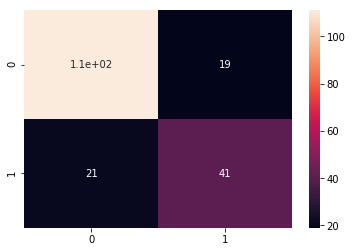

In [107]:
conf_matrix = confusion_matrix(y_test, best_gbc.predict(x_test))
print(conf_matrix)
sb.heatmap(conf_matrix, annot=True)

<span style="color:red">TODO:</span>

<span style="color:blue">2) Can the final model you constructed be deployed at the hospital to diagnose patients automatically?  How would the doctors explain the prediction results to the patients?  Write down any of your opinions or concerns. *(2 points)*</span>

<span style="color:red">No</span>